In [3]:
# === PASO 1: Limpieza y combinación de bases ===
import pandas as pd

# Cargar archivos CSV
clientes = pd.read_csv('base_clientes_final.csv')
transacciones = pd.read_csv('base_transacciones_final.csv')

# Limpiar nombres de columnas por si acaso
clientes.rename(columns=lambda x: x.strip(), inplace=True)
transacciones.rename(columns=lambda x: x.strip(), inplace=True)

# Combinar las bases usando 'id',,,
base_completa = transacciones.merge(clientes, on='id', how='left')

# Llenar nulos en giro_comercio
base_completa['giro_comercio'].fillna("SIN CLASIFICAR", inplace=True)

# Vista previa
print("Vista previa de la base combinada:")
print(base_completa.head())

# Guardar base combinada
base_completa.to_csv('base_completa.csv', index=False)
print("\n¡Archivo guardado como 'base_completa.csv'!")


/var/folders/22/pgty7krs2sldhc8zl8xgk9pm0000gn/T/ipykernel_54401/3211244414.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_completa['giro_comercio'].fillna("SIN CLASIFICAR", inplace=True)


Vista previa de la base combinada:
                                         id       fecha comercio  \
0  91477f382c3cf63ab5cd9263b502109243741158  2022-01-02   AMAZON   
1  91477f382c3cf63ab5cd9263b502109243741158  2022-01-05    RAPPI   
2  91477f382c3cf63ab5cd9263b502109243741158  2022-01-05    RAPPI   
3  91477f382c3cf63ab5cd9263b502109243741158  2022-01-05   AMAZON   
4  91477f382c3cf63ab5cd9263b502109243741158  2022-01-05   AMAZON   

                                giro_comercio tipo_venta  monto  \
0  COMERCIOS ELECTRONICOS (VTAS POR INTERNET)    digital   5.99   
1   SERVICIOS EMPRESARIALES - NO CLASIFICADOS    digital  13.01   
2   SERVICIOS EMPRESARIALES - NO CLASIFICADOS    digital  15.84   
3  COMERCIOS ELECTRONICOS (VTAS POR INTERNET)    digital   8.17   
4  COMERCIOS ELECTRONICOS (VTAS POR INTERNET)    digital   2.54   

  fecha_nacimiento  fecha_alta  id_municipio  id_estado  \
0       1987-09-21  2019-10-28       6519019         65   
1       1987-09-21  2019-10-28     

In [5]:
# PASO 2: Calcular meses_distintos por cliente–comercio
# Asegurarse que la fecha sea tipo datetime
base_completa['fecha'] = pd.to_datetime(base_completa['fecha'])

# Crear columna año-mes
base_completa['año_mes'] = base_completa['fecha'].dt.to_period('M')

# Agrupar por cliente y comercio para contar meses distintos
frecuencia_mensual = (
    base_completa.groupby(['id', 'comercio'])['año_mes']
    .nunique()
    .reset_index(name='meses_distintos')
)


Matplotlib is building the font cache; this may take a moment.


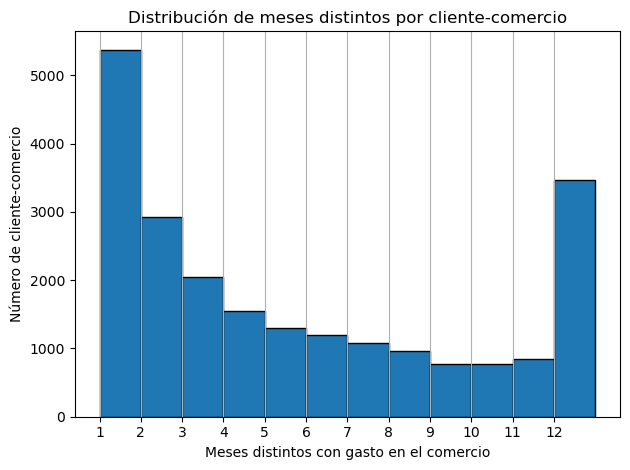

In [6]:
#CÓDIGO DEL PASO 3:

import matplotlib.pyplot as plt

# Histograma de meses distintos por cliente-comercio
frecuencia_mensual['meses_distintos'].hist(bins=12, edgecolor='black')
plt.xlabel("Meses distintos con gasto en el comercio")
plt.ylabel("Número de cliente-comercio")
plt.title("Distribución de meses distintos por cliente-comercio")
plt.xticks(range(1, 13))  # Meses del 1 al 12
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [13]:
# === PASO 4: Crear etiquetas combinadas ===


# === CONTINUACIÓN DESDE PASO 2 ===

# 3. Calcular promedio, std y número de transacciones por cliente-comercio
agrupado_montos = base_completa.groupby(['id', 'comercio'])['monto'].agg(
    monto_prom='mean',
    monto_std='std',
    num_transacciones='count'
).reset_index()

# Unir con frecuencia_mensual
frecuencia_mensual = frecuencia_mensual.merge(agrupado_montos, on=['id', 'comercio'], how='left')

# 4. Calcular rupturas de meses consecutivos
def contar_saltes(meses):
    meses_ordenados = sorted(meses.unique())
    diferencias = [meses_ordenados[i+1] - meses_ordenados[i] for i in range(len(meses_ordenados)-1)]
    return sum([d.n != 1 for d in diferencias])  # d.n convierte a valor numérico

rupturas = (
    base_completa.groupby(['id', 'comercio'])['año_mes']
    .apply(contar_saltes)
    .reset_index(name='meses_no_consecutivos')
)

# Unir con frecuencia_mensual
frecuencia_mensual = frecuencia_mensual.merge(rupturas, on=['id', 'comercio'], how='left')

# 5. Crear etiquetas

# General: recurrente si cumple ≥7 meses, estabilidad en monto y pocos saltos
frecuencia_mensual['es_recurrente'] = (
    (frecuencia_mensual['meses_distintos'] >= 7) &
    (frecuencia_mensual['monto_std'] < 100) &
    (frecuencia_mensual['meses_no_consecutivos'] <= 2)
).astype(int)

# Fuerte: exactamente 12 meses de gasto
frecuencia_mensual['es_recurrente_fuerte'] = (
    frecuencia_mensual['meses_distintos'] == 12
).astype(int)

# 6. Vista previa y exportación
print(frecuencia_mensual.sort_values(by='meses_distintos', ascending=False).head())

frecuencia_mensual.to_csv('frecuencia_mensual_etiquetada.csv', index=False)
print("\n¡Archivo guardado como 'frecuencia_mensual_etiquetada.csv'!")


MergeError: Passing 'suffixes' which cause duplicate columns {'num_transacciones_x', 'monto_prom_x', 'monto_std_x'} is not allowed.

KeyError: 'meses_no_consecutivos'